In [1]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.distributions.normal import Normal
from torch.optim import Adam
import numpy as np
import gym
from gym.spaces import Discrete, Box

In [2]:
def mlp(sizes, activation=nn.Tanh, output_activation=nn.Identity):
    # Build a feedforward neural network.
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

In [21]:
env_name='CartPole-v0'
hidden_sizes=[32]
lr=1e-2
epochs=500
batch_size=5000
render=False

# make environment, check spaces, get obs / act dims
env = gym.make(env_name)
assert isinstance(env.observation_space, Box), \
    "This example only works for envs with continuous state spaces."
assert isinstance(env.action_space, Discrete), \
    "This example only works for envs with discrete action spaces."

obs_dim = env.observation_space.shape[0]
n_acts = env.action_space.n

# make core of policy network
logits_net = mlp(sizes=[obs_dim]+hidden_sizes+[n_acts])

# make function to compute action distribution
def get_policy(obs):
    logits = logits_net(obs)
    return Categorical(logits=logits)

# make action selection function (outputs int actions, sampled from policy)
def get_action(obs):
    return get_policy(obs).sample().item()

# make loss function whose gradient, for the right data, is policy gradient
def compute_loss(obs, act, weights):
    logp = get_policy(obs).log_prob(act)
    return -(logp * weights).mean()

def reward_to_go(rews):
    n = len(rews)
    rtgs = np.zeros_like(rews)
    for i in reversed(range(n)):
        rtgs[i] = rews[i] + (rtgs[i+1] if i+1 < n else 0)
    return rtgs

# make optimizer
optimizer = Adam(logits_net.parameters(), lr=lr)


In [22]:
# for training policy
def train_one_epoch():
    # make some empty lists for logging.
    batch_obs = []          # for observations
    batch_acts = []         # for actions
    batch_weights = []      # for R(tau) weighting in policy gradient
    batch_weights2 = []
    batch_rets = []         # for measuring episode returns
    batch_lens = []         # for measuring episode lengths

    # reset episode-specific variables
    obs = env.reset()       # first obs comes from starting distribution
    done = False            # signal from environment that episode is over
    ep_rews = []            # list for rewards accrued throughout ep

    # render first episode of each epoch
    finished_rendering_this_epoch = False

    # collect experience by acting in the environment with current policy
    while True:

        # rendering
        if (not finished_rendering_this_epoch) and render:
            env.render()

        # save obs
        batch_obs.append(obs.copy())

        # act in the environment
        act = get_action(torch.as_tensor(obs, dtype=torch.float32))
        obs, rew, done, _ = env.step(act)

        # save action, reward
        batch_acts.append(act)
        ep_rews.append(rew)
        #print (ep_rews)
        
        if done:
            
            # if episode is over, record info about episode
            ep_ret, ep_len = sum(ep_rews), len(ep_rews)
            
            #if max_x > -0.2:
            #    ep_ret = 1
            #print (ep_ret)
            batch_rets.append(ep_ret)
            batch_lens.append(ep_len)

            # the weight for each logprob(a|s) is R(tau)
            #batch_weights += [ep_ret] * ep_len
            batch_weights += list(reward_to_go(ep_rews))
            #print ('>', batch_weights)
            #print ('>>', batch_weights2)
            
            
            
            # reset episode-specific variables
            obs, done, ep_rews = env.reset(), False, []

            # won't render again this epoch
            finished_rendering_this_epoch = True

            # end experience loop if we have enough of it
            if len(batch_obs) > batch_size:
                break
            
    #print (ep_rews)
    #print (len(batch_obs) , len(batch_acts))
    #print (batch_obs[0], batch_acts[0])
    # take a single policy gradient update step
    optimizer.zero_grad()
    batch_loss = compute_loss(obs=torch.as_tensor(batch_obs, dtype=torch.float32),
                              act=torch.as_tensor(batch_acts, dtype=torch.int32),
                              weights=torch.as_tensor(batch_weights, dtype=torch.float32)
                              )
    batch_loss.backward()
    optimizer.step()
    return batch_loss, batch_rets, batch_lens, batch_obs

In [23]:
for i in range(1):
    batch_loss, batch_rets, batch_lens, batch_obs = train_one_epoch()
#print (batch_rets)

In [24]:
# training loop
logs = []
for i in range(epochs):
    batch_loss, batch_rets, batch_lens,_ = train_one_epoch()
    logs.append((batch_loss, batch_rets, batch_lens))
    print('epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f'%
            (i, batch_loss, np.mean(batch_rets), np.mean(batch_lens)))

epoch:   0 	 loss: 11.674 	 return: 25.439 	 ep_len: 25.439
epoch:   1 	 loss: 12.183 	 return: 27.966 	 ep_len: 27.966
epoch:   2 	 loss: 13.405 	 return: 30.693 	 ep_len: 30.693
epoch:   3 	 loss: 14.745 	 return: 33.112 	 ep_len: 33.112
epoch:   4 	 loss: 15.229 	 return: 35.921 	 ep_len: 35.921
epoch:   5 	 loss: 18.406 	 return: 42.432 	 ep_len: 42.432
epoch:   6 	 loss: 16.434 	 return: 42.653 	 ep_len: 42.653
epoch:   7 	 loss: 18.071 	 return: 46.505 	 ep_len: 46.505
epoch:   8 	 loss: 19.008 	 return: 47.924 	 ep_len: 47.924
epoch:   9 	 loss: 21.538 	 return: 53.489 	 ep_len: 53.489
epoch:  10 	 loss: 17.590 	 return: 49.752 	 ep_len: 49.752
epoch:  11 	 loss: 19.927 	 return: 56.404 	 ep_len: 56.404
epoch:  12 	 loss: 20.265 	 return: 55.571 	 ep_len: 55.571
epoch:  13 	 loss: 21.762 	 return: 63.175 	 ep_len: 63.175
epoch:  14 	 loss: 23.300 	 return: 66.671 	 ep_len: 66.671
epoch:  15 	 loss: 23.332 	 return: 68.616 	 ep_len: 68.616
epoch:  16 	 loss: 24.818 	 return: 72.7

epoch: 133 	 loss: 38.368 	 return: 155.091 	 ep_len: 155.091
epoch: 134 	 loss: 46.661 	 return: 191.259 	 ep_len: 191.259
epoch: 135 	 loss: 46.742 	 return: 196.115 	 ep_len: 196.115
epoch: 136 	 loss: 46.785 	 return: 200.000 	 ep_len: 200.000
epoch: 137 	 loss: 48.485 	 return: 200.000 	 ep_len: 200.000
epoch: 138 	 loss: 47.706 	 return: 200.000 	 ep_len: 200.000
epoch: 139 	 loss: 47.909 	 return: 200.000 	 ep_len: 200.000
epoch: 140 	 loss: 47.436 	 return: 200.000 	 ep_len: 200.000
epoch: 141 	 loss: 47.871 	 return: 200.000 	 ep_len: 200.000
epoch: 142 	 loss: 47.572 	 return: 200.000 	 ep_len: 200.000
epoch: 143 	 loss: 46.608 	 return: 200.000 	 ep_len: 200.000
epoch: 144 	 loss: 47.534 	 return: 200.000 	 ep_len: 200.000
epoch: 145 	 loss: 47.062 	 return: 200.000 	 ep_len: 200.000
epoch: 146 	 loss: 45.617 	 return: 200.000 	 ep_len: 200.000
epoch: 147 	 loss: 46.473 	 return: 200.000 	 ep_len: 200.000
epoch: 148 	 loss: 46.698 	 return: 200.000 	 ep_len: 200.000
epoch: 1

epoch: 266 	 loss: 31.239 	 return: 197.885 	 ep_len: 197.885
epoch: 267 	 loss: 31.794 	 return: 198.808 	 ep_len: 198.808
epoch: 268 	 loss: 31.218 	 return: 200.000 	 ep_len: 200.000
epoch: 269 	 loss: 31.293 	 return: 200.000 	 ep_len: 200.000
epoch: 270 	 loss: 31.380 	 return: 200.000 	 ep_len: 200.000
epoch: 271 	 loss: 31.433 	 return: 200.000 	 ep_len: 200.000
epoch: 272 	 loss: 30.849 	 return: 200.000 	 ep_len: 200.000
epoch: 273 	 loss: 30.177 	 return: 200.000 	 ep_len: 200.000
epoch: 274 	 loss: 30.553 	 return: 200.000 	 ep_len: 200.000
epoch: 275 	 loss: 29.896 	 return: 200.000 	 ep_len: 200.000
epoch: 276 	 loss: 30.685 	 return: 200.000 	 ep_len: 200.000
epoch: 277 	 loss: 29.739 	 return: 200.000 	 ep_len: 200.000
epoch: 278 	 loss: 29.940 	 return: 200.000 	 ep_len: 200.000
epoch: 279 	 loss: 30.091 	 return: 200.000 	 ep_len: 200.000
epoch: 280 	 loss: 30.713 	 return: 200.000 	 ep_len: 200.000
epoch: 281 	 loss: 30.030 	 return: 200.000 	 ep_len: 200.000
epoch: 2

epoch: 399 	 loss: 22.005 	 return: 200.000 	 ep_len: 200.000
epoch: 400 	 loss: 21.647 	 return: 200.000 	 ep_len: 200.000
epoch: 401 	 loss: 21.411 	 return: 200.000 	 ep_len: 200.000
epoch: 402 	 loss: 21.831 	 return: 200.000 	 ep_len: 200.000
epoch: 403 	 loss: 22.588 	 return: 200.000 	 ep_len: 200.000
epoch: 404 	 loss: 21.936 	 return: 200.000 	 ep_len: 200.000
epoch: 405 	 loss: 20.278 	 return: 200.000 	 ep_len: 200.000
epoch: 406 	 loss: 21.448 	 return: 200.000 	 ep_len: 200.000
epoch: 407 	 loss: 22.744 	 return: 200.000 	 ep_len: 200.000
epoch: 408 	 loss: 21.757 	 return: 200.000 	 ep_len: 200.000
epoch: 409 	 loss: 22.779 	 return: 200.000 	 ep_len: 200.000
epoch: 410 	 loss: 20.371 	 return: 200.000 	 ep_len: 200.000
epoch: 411 	 loss: 20.114 	 return: 200.000 	 ep_len: 200.000
epoch: 412 	 loss: 21.493 	 return: 200.000 	 ep_len: 200.000
epoch: 413 	 loss: 23.775 	 return: 200.000 	 ep_len: 200.000
epoch: 414 	 loss: 22.040 	 return: 200.000 	 ep_len: 200.000
epoch: 4

In [25]:
print (len(logs), logs[0][0], len(logs[0][1]), len(logs[0][2]))

500 tensor(11.6736, grad_fn=<NegBackward>) 198 198


In [26]:
returns = list(zip(*logs))[1]

In [27]:
import matplotlib.pyplot as plt

In [28]:
mean_returns = [np.mean(x) for x in returns]

In [29]:
print (mean_returns)

[25.439393939393938, 27.966480446927374, 30.69325153374233, 33.11184210526316, 35.92142857142857, 42.432203389830505, 42.652542372881356, 46.5045871559633, 47.923809523809524, 53.48936170212766, 49.75247524752475, 56.40449438202247, 55.57142857142857, 63.175, 66.67105263157895, 68.61643835616438, 72.7536231884058, 73.83823529411765, 79.66666666666667, 85.57627118644068, 97.58490566037736, 113.79545454545455, 136.27027027027026, 133.31578947368422, 143.5142857142857, 134.18421052631578, 161.96875, 164.32258064516128, 157.09375, 167.48387096774192, 173.3793103448276, 189.03703703703704, 188.0, 196.5, 198.3846153846154, 200.0, 200.0, 194.46153846153845, 199.42307692307693, 200.0, 200.0, 199.5, 200.0, 199.65384615384616, 198.34615384615384, 196.15384615384616, 193.6153846153846, 195.23076923076923, 189.40740740740742, 193.5, 190.59259259259258, 190.77777777777777, 189.74074074074073, 187.55555555555554, 182.78571428571428, 181.75, 178.78571428571428, 178.60714285714286, 186.55555555555554,

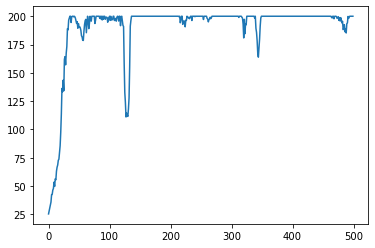

In [30]:
plt.plot(mean_returns)